In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

maxdate = session.query(func.max(Measurement.date)).first()[0]
last_year = (pd.to_datetime(maxdate)- dt.timedelta(365)).date().strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
Rainfall_2017 = session.query(*sel).filter(Measurement.date.between(last_year, maxdate)).order_by('date')


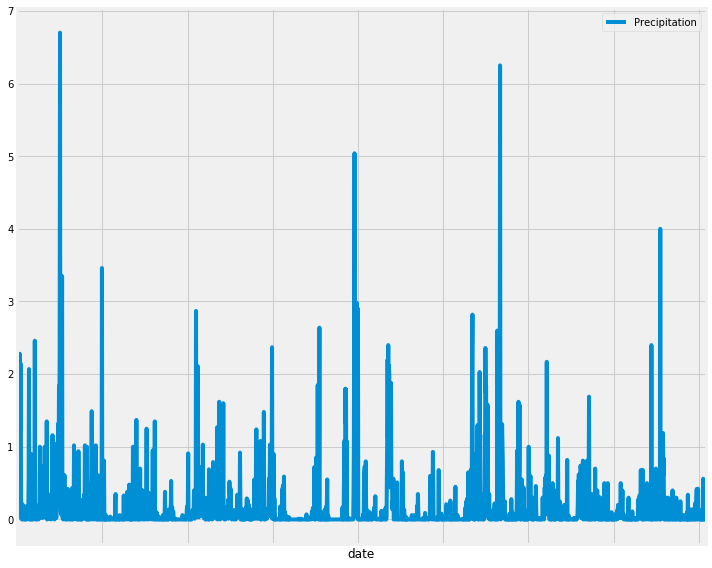

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(Rainfall_2017)
df.set_index('date', inplace=True)
df.dropna(inplace=True)
df.head()

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,8))
plt.xlabel("date")
plt.ylabel("")
plt.title("")
plt.legend(["Precipitation"])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(session.query(Measurement.station).group_by(Measurement.station))).all()


[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.

top_stations = session.query(Measurement.station, func.count(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc())\
.all()

top_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station == top_stations[0].station).all()

[(54.0, 85.0, 71.66378066378067)]

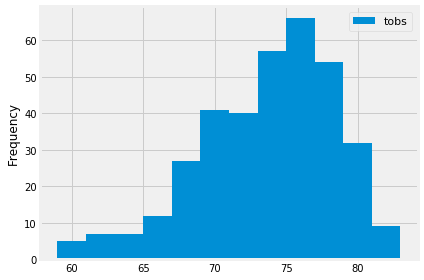

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, Measurement.date, Measurement.tobs]

highest_obs = session.query(*sel).filter(Measurement.station == top_stations[0].station).all()

maxdate = highest_obs[-1].date
last_year = (pd.to_datetime(maxdate) - dt.timedelta(365)).strftime('%Y-%m-%d')


temperature = session.query(*sel).filter(Measurement.date.between(last_year, maxdate))\
.filter(Measurement.station == top_stations[0].station)\
.order_by('date').all()

temp_df = pd.DataFrame(temperature, columns=['station', 'date', 'tobs'])
plt.hist(temp_df['tobs'],12)
plt.legend(('tobs', " "), loc='best', prop={'size':11})
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-16', '2017-05-30'))

[(68.0, 74.90588235294118, 87.0)]


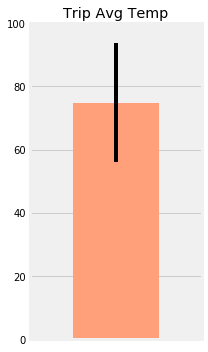

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temps = calc_temps('2017-05-16', '2017-05-30')
trip_df = pd.DataFrame(trip_temps, columns=['Minimum', 'Average', 'Maximum'])
errors = trip_df['Maximum'] - trip_df['Minimum']
avg_temp = trip_df['Average']
avg_temp.plot.bar(color='lightsalmon', yerr=errors, figsize=(3,5))
plt.ylim(0,100)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.savefig("Images/trip_temp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

stations = session.query(*sel, func.sum(Measurement.prcp))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date.between('2016-05-16', '2016-05-30'))\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc())\
.all()

np.ravel(stations)

array(['USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025,
       152.4, 4.1, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167,
       -157.84888999999998, 32.9, 1.8300000000000003, 'USC00513117',
       'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6,
       1.2400000000000002, 'USC00514830',
       'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0,
       1.12, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168,
       3.0, 0.9, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US',
       21.33556, -157.71139, 19.5, 0.42, 'USC00517948',
       'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None], dtype=object)

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


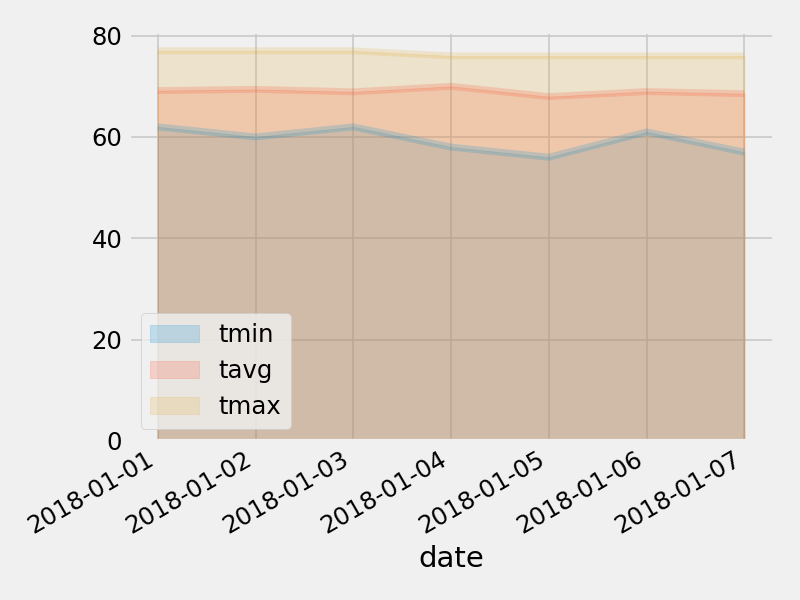

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
